In [90]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [177]:
PART = 'presentation'
#PART = 'QnA'

In [184]:
# import system_message.txt as a string
with open('prompts/system_message.txt', 'r') as file:
    system_message = file.read()

print(system_message)

Context:
You are an advanced AI language model trained to analyze financial documents. Your task is to analyze the last earnings call transcripts before default of companies and extract specific textual features, sentiment scores, and key financial metrics. These features will be used to predict the recovery rate of bonds, defined as the 30-day average bond price after default, issued by these companies.

Objective:
Given the provided earnings call transcript, perform the following tasks:

Extract Financial Sentiment Scores:
Evaluate the financial sentiment expressed throughout the earnings call using the following unique categories:
[Score1] Financial Sentiment (-1.00 to 1.00): Combine the negative and positive sentiment into a single score reflecting the overall financial tone of the earnings call.
Negative Range (-1.00 to 0.00): Indicates predominant negative financial language (e.g., risks, losses, challenges, declining revenues, increased expenses).
Positive Range (0.00 to 1.00): 

In [185]:
bond_level = pd.read_csv('transcripts/credit_df.csv', delimiter='|')
aggregated = pd.read_csv('transcripts/aggregated_credit_df.csv', delimiter='|')

In [186]:
client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [187]:
for idx, row in aggregated.iterrows():
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": row[PART]}
            ]
        )
        # Instantly add the output as a new column entry for the corresponding row
        response = completion.choices[0].message.content

        print(f"Completed for row {idx}")
        print(response)

        # Parse response columns and populate the DataFrame
        if float(response.split('; ')[0]) >= 0:
            aggregated.at[idx, 'positive_sentiment'] = float(response.split('; ')[0])
            aggregated.at[idx, 'negative_sentiment'] = 0
        else:
            aggregated.at[idx, 'positive_sentiment'] = 0
            aggregated.at[idx, 'negative_sentiment'] = float(response.split('; ')[0]) * -1

        aggregated.at[idx, 'uncertainty'] = float(response.split('; ')[1])

        if float(response.split('; ')[2]) >= 0:
            aggregated.at[idx, 'optimism'] = float(response.split('; ')[2])
            aggregated.at[idx, 'pessimism'] = 0
        else:
            aggregated.at[idx, 'optimism'] = 0
            aggregated.at[idx, 'pessimism'] = float(response.split('; ')[2]) * -1

        aggregated.at[idx, 'vagueness'] = float(response.split('; ')[3])
        aggregated.at[idx, 'liquidity_position'] = float(response.split('; ')[4])
        aggregated.at[idx, 'debt_leverage_stress'] = float(response.split('; ')[5])
        aggregated.at[idx, 'operational_trends'] = float(response.split('; ')[6])
        aggregated.at[idx, 'industry_positioning'] = float(response.split('; ')[7])
        aggregated.at[idx, 'asset_quality'] = float(response.split('; ')[8])
        aggregated.at[idx, 'recovery_strategies'] = float(response.split('; ')[9])
        aggregated.at[idx, 'legal_issues'] = float(response.split('; ')[10])
        aggregated.at[idx, 'macroeconomic'] = float(response.split('; ')[11])

    except openai.error.OpenAIError as e:
        print(f"An exception occurred: {e}")
        print("Waiting for 1 minute before retrying...")
        time.sleep(60)


Completed for row 0
0.10; 0.30; -0.20; 0.40; 0.50; 0.70; 0.40; 0.60; 0.50; 0.40; 0.30; 0.60
Completed for row 1
0.20; 0.40; 0.10; 0.60; 0.50; 0.30; 0.40; 0.50; 0.30; 0.40; 0.20; 0.50
Completed for row 2
-0.45; 0.60; -0.30; 0.70; 0.40; 0.20; 0.50; 0.60; 0.30; 0.50; 0.40; 0.70
Completed for row 3
0.10; 0.80; 0.20; 0.70; 0.40; 0.60; 0.50; 0.70; 0.60; 0.50; 0.40; 0.70
Completed for row 4
0.25; 0.60; 0.30; 0.40; 0.70; 0.40; 0.60; 0.50; 0.60; 0.50; 0.30; 0.40
Completed for row 5
0.20; 0.60; 0.30; 0.40; 0.80; 0.40; 0.60; 0.70; 0.80; 0.70; 0.40; 0.50
Completed for row 6
-0.75; 0.80; -0.60; 0.70; 0.80; 0.40; 0.60; 0.70; 0.50; 0.60; 0.30; 0.90
Completed for row 7
0.25; 0.60; -0.20; 0.50; 0.40; 0.70; 0.30; 0.50; 0.40; 0.30; 0.20; 0.60
Completed for row 8
-0.75; 0.80; -0.70; 0.60; 0.90; 0.80; 0.50; 0.70; 0.40; 0.60; 0.80; 0.90
Completed for row 9
0.10; 0.30; 0.20; 0.40; 0.50; 0.60; 0.40; 0.50; 0.30; 0.40; 0.20; 0.30
Completed for row 10
0.10; 0.80; 0.20; 0.60; 0.70; 0.40; 0.30; 0.50; 0.60; 0.40; 0

In [189]:
llm_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimism', 'pessimism', 'vagueness',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

# merge output_df with transcripts on 'transcript_number' and index
bond_level = pd.merge(bond_level,
                          aggregated[llm_labels + ['call_ID']],
                          on=['call_ID'],
                          how='left')

checkpoint = bond_level.copy()

In [190]:
# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
checkpoint.replace('#DIV/0!', np.nan, inplace=True)
checkpoint = checkpoint.fillna(0)

# make sure all values are numeric except for the Date column
checkpoint = checkpoint.apply(pd.to_numeric, errors='ignore')

In [204]:
# save checkpoint as csv
checkpoint.to_csv('transcripts/LLM_outputs.csv', index=False)
#checkpoint = pd.read_csv('transcripts/LLM_outputs_QnA.csv')

In [191]:
# List of selected supporting features
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [196]:
'''COMPANY LEVEL'''

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['call_ID']
                    + supporting_features_1
                    + supporting_features_2
                    + llm_labels 
                    + ['aggregated_RR']]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

y_train, y_test = final_df['aggregated_RR'], final_df['aggregated_RR']
X_train, X_test = final_df.drop(columns=['aggregated_RR', 'call_ID']), final_df.drop(columns=['aggregated_RR', 'call_ID'])

                            OLS Regression Results                            
Dep. Variable:          aggregated_RR   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     84.02
Date:                Tue, 08 Oct 2024   Prob (F-statistic):          3.31e-293
Time:                        13:46:19   Log-Likelihood:                -4143.8
No. Observations:                1075   AIC:                             8370.
Df Residuals:                    1034   BIC:                             8574.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

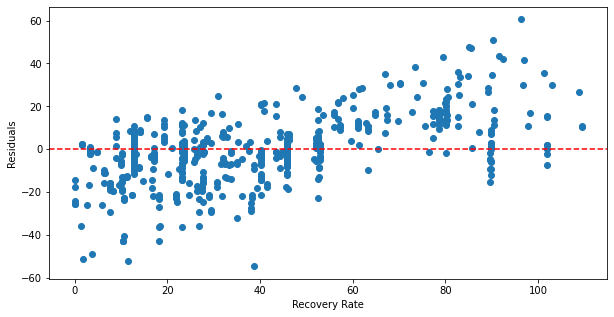

In [197]:
# LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [198]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3465.012493
31                                 pessimism    40.409647
27                        negative_sentiment    33.152212
17                                Financials    17.153148
29                               uncertainty    14.873423
28                        positive_sentiment    13.069244
40                             macroeconomic    11.771907
30                                  optimism    10.505942
32                                 vagueness     9.797525
11                      ActIndustryDistress1     8.778646
39                              legal_issues     7.774471
4         30 year conventional mortgage rate     7.762143
3   Manufacturers inventories to sales ratio     7.587957
2                    NASDAQ 100 Index return     7.518642
34                      debt_leverage_stress     5.429674
12                      ActIndustryDistress2     5.279217
1             

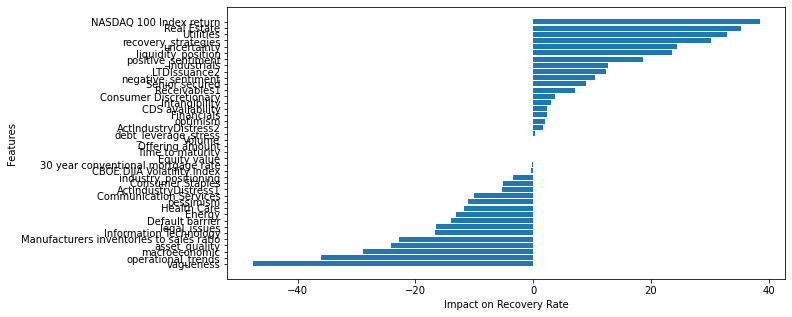

In [199]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()

In [200]:

'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['Date'] 
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + ['RR']]

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR', 'Date']), final_df.drop(columns=['RR', 'Date'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     53.65
Date:                Tue, 08 Oct 2024   Prob (F-statistic):          8.22e-113
Time:                        13:47:55   Log-Likelihood:                -4733.8
No. Observations:                1075   AIC:                             9498.
Df Residuals:                    1060   BIC:                             9572.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  118.8944 

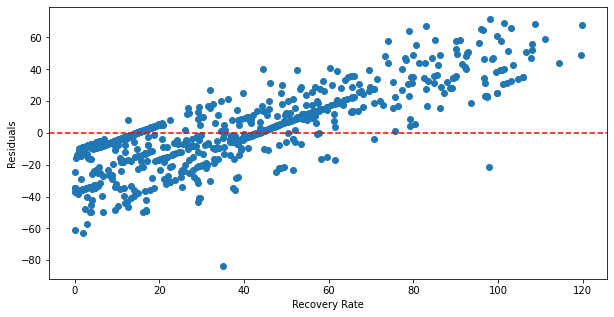

In [201]:
# LLM features QnA

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [202]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                Features         VIF
0                  const  137.404379
5              pessimism   32.091829
1     negative_sentiment   29.750549
3            uncertainty   11.998838
2     positive_sentiment   10.567014
14         macroeconomic    9.499238
4               optimism    7.695283
6              vagueness    6.383880
8   debt_leverage_stress    4.474279
13          legal_issues    2.999882
9     operational_trends    2.957015
12   recovery_strategies    2.315069
11         asset_quality    2.187567
7     liquidity_position    2.082323
10  industry_positioning    1.750777


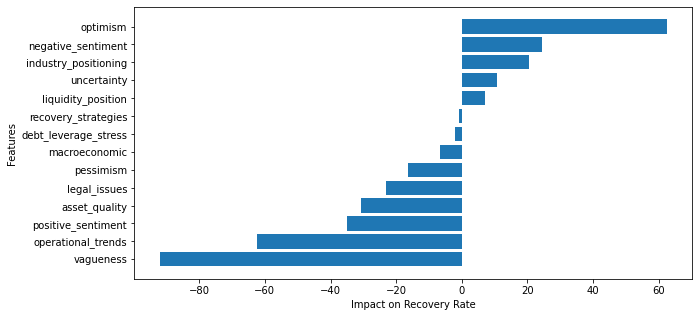

In [203]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Impact on Recovery Rate')
plt.ylabel('Features')
plt.show()